In [30]:
import os
import sys 
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import plotly
import plotly.graph_objects as go
import plotly.express as px
import kaleido ##pip install -U kaleido ##to save a plotly fig
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score,cross_val_predict

In [46]:
df1 = pd.read_csv('Stable_Data_CSV.csv')
df2 = pd.read_csv('6wUsingBL.csv')
df_stable = df2[df2.set_index(['participant_id']).index.isin(df1.set_index(['participant_id']).index)]

In [47]:
df_stable_US = df_stable.loc[(df_stable['arm'] == 1)]
df_stable_WN = df_stable.loc[(df_stable['arm'] == 2)]
print(len(df_stable_US))
print(len(df_stable_WN))
df_stable_US=(df_stable_US[['c_3','sl_1','a_2','q_1','tfi_total.1','tfi_total.2','tfi_total.3']])
df_stable_WN=(df_stable_WN[['sl_2','r_1','e_1','tfi_total.1','tfi_total.2','tfi_total.3']])

df_stable_WN 

31
30


,sl_2,r_1,e_1,tfi_total.1,tfi_total.2,tfi_total.3
51,5.0,8.0,6.0,64.0,72.4,80.4
52,3.0,5.0,4.0,47.6,64.0,71.2
53,6.0,6.0,3.0,57.2,60.4,64.8
55,3.0,7.0,2.0,37.2,27.6,44.8
56,3.0,3.0,4.0,51.2,55.2,70.0
57,1.0,5.0,6.0,55.2,14.0,14.0
59,5.0,8.0,6.0,55.2,26.0,37.6
60,7.0,7.0,3.0,63.2,73.6,83.2
61,3.0,5.0,5.0,47.2,35.2,42.8
63,1.0,7.0,2.0,51.6,44.0,35.2


In [85]:
# with scaled data
n_epochs=100
n_batch_size=32 #batch training
n_timesteps=1
n_features=4
lr=0.01
kfold = KFold(n_splits=5)
error_scores_US=[]
error_scores_WN=[]

def data_prep(df):
    sc_x=StandardScaler()
    sc_y=StandardScaler()
    ## Separate dependent and independent features 
    X=df.drop(['tfi_total.2','tfi_total.3'],axis=1).values
    y = df[['tfi_total.2']].values
    #scale x
    x_scaler=sc_x.fit(X)
    X=x_scaler.transform(X)
    #scale y
    y_scaler=sc_y.fit(y)
    y=y_scaler.transform(y)
    # Reshape input to be 3D for LSTM[samples, timesteps, features]
    X = X.reshape((X.shape[0],n_timesteps,X.shape[1]))
    print(X.shape,y.shape)
    input_shape=(n_timesteps,X.shape[2])
    print(input_shape)
    return X,y,input_shape,x_scaler,y_scaler

def create_lstm_model(input_shape,y_scaler):
    
    def error_in_tfi(y_true,y_pred): 
        y=y_true.numpy()
        yhat=y_pred.numpy()
        y=np.reshape(y, (1,-1))
        yhat=np.reshape(yhat, (1,-1))
        y=y_scaler.inverse_transform(y)
        yhat=y_scaler.inverse_transform(yhat)
        y=tf.convert_to_tensor(y, dtype=tf.float32)
        yhat=tf.convert_to_tensor(yhat, dtype=tf.float32)
        return K.mean(abs(y - yhat), axis=-1)  #K.mean(square(y_true - y_pred), axis=-1)
    
    K.clear_session
    input_shape=input_shape
    model = Sequential([
      LSTM(50, activation='relu',kernel_regularizer=regularizers.L1L2(l1=0.1, l2=0.1),input_shape=input_shape),#kernel_initializer='normal'
      Dropout(0.2), # 20% of Neuron will get deactivated during training
      Dense(1,kernel_initializer='normal',activation = 'linear')                      
    ])             

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr),run_eagerly=True,metrics=[error_in_tfi])
    return model
    
def cross_val(df,error_scores):
    X,y,input_shape,x_scaler,y_scaler=data_prep(df)
    for train_index, test_index in kfold.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model=create_lstm_model(input_shape,y_scaler)
        history=model.fit(x_train, y_train,epochs=n_epochs,batch_size=n_batch_size,verbose =1)#validation_data=(x_test,y_test) #validation_split=0.2
        val_mse,val_mae=model.evaluate(x_test,y_test) #evaluating using unseen data, bcz validation is not used while model.fit
        error_scores.append(val_mae)
    return history,x_scaler,y_scaler,error_scores

US_history,US_x_scaler,US_y_scaler,US_error_scores=cross_val(df_stable_US,error_scores_US)
WN_history,WN_x_scaler,WN_y_scaler,WN_error_scores=cross_val(df_stable_WN,error_scores_WN)

(31, 1, 5) (31, 1)
(1, 5)
TRAIN: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30] TEST: [0 1 2 3 4 5 6]
Epoch 1/100
1/1 [==============================] - 0s 38ms/step - loss: 10.3025 - error_in_tfi: 16.1353
Epoch 2/100
1/1 [==============================] - 0s 33ms/step - loss: 9.2153 - error_in_tfi: 16.1021
Epoch 3/100
1/1 [==============================] - 0s 33ms/step - loss: 8.1923 - error_in_tfi: 16.0402
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 7.2605 - error_in_tfi: 15.9969
Epoch 5/100
1/1 [==============================] - 0s 32ms/step - loss: 6.4082 - error_in_tfi: 15.9456
Epoch 6/100
1/1 [==============================] - 0s 32ms/step - loss: 5.6384 - error_in_tfi: 15.9102
Epoch 7/100
1/1 [==============================] - 0s 30ms/step - loss: 4.9533 - error_in_tfi: 15.8751
Epoch 8/100
1/1 [==============================] - 0s 29ms/step - loss: 4.3483 - error_in_tfi: 15.8488
Epoch 9/100
1/1 [=============================

1/1 [==============================] - 0s 28ms/step - loss: 1.0304 - error_in_tfi: 15.9434
Epoch 78/100
1/1 [==============================] - 0s 29ms/step - loss: 1.0332 - error_in_tfi: 15.9414
Epoch 79/100
1/1 [==============================] - 0s 28ms/step - loss: 1.0309 - error_in_tfi: 15.9812
Epoch 80/100
1/1 [==============================] - 0s 28ms/step - loss: 1.0224 - error_in_tfi: 15.9023
Epoch 81/100
1/1 [==============================] - 0s 28ms/step - loss: 1.0231 - error_in_tfi: 15.8280
Epoch 82/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0296 - error_in_tfi: 15.8921
Epoch 83/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0497 - error_in_tfi: 16.0332
Epoch 84/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0364 - error_in_tfi: 16.0038
Epoch 85/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0222 - error_in_tfi: 15.8928
Epoch 86/100
1/1 [==============================] - 0s 28ms/step - loss: 1.01

1/1 [==============================] - 0s 28ms/step - loss: 1.6127 - error_in_tfi: 15.5014
Epoch 28/100
1/1 [==============================] - 0s 27ms/step - loss: 1.5411 - error_in_tfi: 15.5650
Epoch 29/100
1/1 [==============================] - 0s 27ms/step - loss: 1.4766 - error_in_tfi: 15.5059
Epoch 30/100
1/1 [==============================] - 0s 28ms/step - loss: 1.4439 - error_in_tfi: 15.5738
Epoch 31/100
1/1 [==============================] - 0s 28ms/step - loss: 1.4097 - error_in_tfi: 15.4449
Epoch 32/100
1/1 [==============================] - 0s 27ms/step - loss: 1.4108 - error_in_tfi: 15.5480
Epoch 33/100
1/1 [==============================] - 0s 28ms/step - loss: 1.4068 - error_in_tfi: 15.4733
Epoch 34/100
1/1 [==============================] - 0s 27ms/step - loss: 1.4197 - error_in_tfi: 15.5394
Epoch 35/100
1/1 [==============================] - 0s 27ms/step - loss: 1.3992 - error_in_tfi: 15.5281
Epoch 36/100
1/1 [==============================] - 0s 27ms/step - loss: 1.37

Epoch 81/100
1/1 [==============================] - 0s 27ms/step - loss: 0.9849 - error_in_tfi: 13.3408
Epoch 82/100
1/1 [==============================] - 0s 28ms/step - loss: 1.1165 - error_in_tfi: 13.9464
Epoch 83/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0429 - error_in_tfi: 13.9326
Epoch 84/100
1/1 [==============================] - 0s 26ms/step - loss: 1.0518 - error_in_tfi: 14.1792
Epoch 85/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0001 - error_in_tfi: 13.3233
Epoch 86/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0280 - error_in_tfi: 13.8141
Epoch 87/100
1/1 [==============================] - 0s 27ms/step - loss: 1.1319 - error_in_tfi: 14.9583
Epoch 88/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0120 - error_in_tfi: 13.2149
Epoch 89/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0595 - error_in_tfi: 14.4623
Epoch 90/100
1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step - loss: 1.3380 - error_in_tfi: 17.3805
Epoch 32/100
1/1 [==============================] - 0s 27ms/step - loss: 1.3194 - error_in_tfi: 17.3216
Epoch 33/100
1/1 [==============================] - 0s 28ms/step - loss: 1.3132 - error_in_tfi: 17.3533
Epoch 34/100
1/1 [==============================] - 0s 28ms/step - loss: 1.3274 - error_in_tfi: 17.3213
Epoch 35/100
1/1 [==============================] - 0s 28ms/step - loss: 1.3213 - error_in_tfi: 17.4145
Epoch 36/100
1/1 [==============================] - 0s 28ms/step - loss: 1.2919 - error_in_tfi: 17.2977
Epoch 37/100
1/1 [==============================] - 0s 27ms/step - loss: 1.2831 - error_in_tfi: 17.2482
Epoch 38/100
1/1 [==============================] - 0s 28ms/step - loss: 1.2501 - error_in_tfi: 17.3190
Epoch 39/100
1/1 [==============================] - 0s 28ms/step - loss: 1.2120 - error_in_tfi: 17.1231
Epoch 40/100
1/1 [==============================] - 0s 27ms/step - loss: 1.19

1/1 [==============================] - 0s 28ms/step - loss: 0.7815 - error_in_tfi: 10.8443
Epoch 85/100
1/1 [==============================] - 0s 27ms/step - loss: 0.8415 - error_in_tfi: 11.7353
Epoch 86/100
1/1 [==============================] - 0s 27ms/step - loss: 0.8557 - error_in_tfi: 11.7532
Epoch 87/100
1/1 [==============================] - 0s 27ms/step - loss: 0.8649 - error_in_tfi: 12.0893
Epoch 88/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9187 - error_in_tfi: 12.6182
Epoch 89/100
1/1 [==============================] - 0s 28ms/step - loss: 0.8018 - error_in_tfi: 11.3430
Epoch 90/100
1/1 [==============================] - 0s 28ms/step - loss: 0.8274 - error_in_tfi: 11.3449
Epoch 91/100
1/1 [==============================] - 0s 28ms/step - loss: 0.7213 - error_in_tfi: 10.5183
Epoch 92/100
1/1 [==============================] - 0s 28ms/step - loss: 0.8216 - error_in_tfi: 11.4612
Epoch 93/100
1/1 [==============================] - 0s 28ms/step - loss: 0.75

1/1 [==============================] - 0s 28ms/step - loss: 1.1106 - error_in_tfi: 14.8725
Epoch 35/100
1/1 [==============================] - 0s 28ms/step - loss: 1.0985 - error_in_tfi: 14.8354
Epoch 36/100
1/1 [==============================] - 0s 28ms/step - loss: 1.0835 - error_in_tfi: 15.0213
Epoch 37/100
1/1 [==============================] - 0s 28ms/step - loss: 1.0567 - error_in_tfi: 14.9479
Epoch 38/100
1/1 [==============================] - 0s 28ms/step - loss: 1.0192 - error_in_tfi: 14.8926
Epoch 39/100
1/1 [==============================] - 0s 28ms/step - loss: 1.0015 - error_in_tfi: 14.9239
Epoch 40/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9598 - error_in_tfi: 14.6332
Epoch 41/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9699 - error_in_tfi: 14.8408
Epoch 42/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9548 - error_in_tfi: 14.6123
Epoch 43/100
1/1 [==============================] - 0s 28ms/step - loss: 0.92

1/1 [==============================] - 0s 28ms/step - loss: 0.9179 - error_in_tfi: 14.2127
Epoch 88/100
1/1 [==============================] - 0s 28ms/step - loss: 1.0054 - error_in_tfi: 15.1711
Epoch 89/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9241 - error_in_tfi: 14.4968
Epoch 90/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9973 - error_in_tfi: 15.3017
Epoch 91/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9220 - error_in_tfi: 14.5359
Epoch 92/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9585 - error_in_tfi: 14.9083
Epoch 93/100
1/1 [==============================] - 0s 27ms/step - loss: 0.9366 - error_in_tfi: 14.5274
Epoch 94/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9216 - error_in_tfi: 14.9691
Epoch 95/100
1/1 [==============================] - 0s 29ms/step - loss: 0.8910 - error_in_tfi: 14.3142
Epoch 96/100
1/1 [==============================] - 0s 28ms/step - loss: 1.01

In [86]:
print(US_error_scores)
print(WN_error_scores)

[17.743131637573242, 16.66762924194336, 18.44281768798828, 15.402488708496094, 17.80345916748047]
[17.724393844604492, 13.297136306762695, 11.601805686950684, 27.081897735595703, 9.653894424438477]


In [87]:
US_error=np.mean(US_error_scores)
print(US_error)
WN_error=np.mean(WN_error_scores)
print(WN_error)

17.21190528869629
15.87182559967041


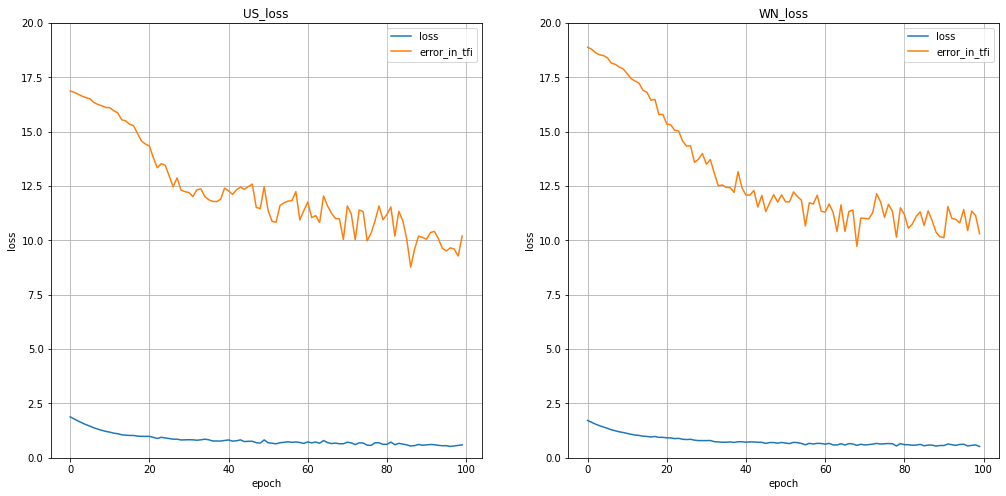

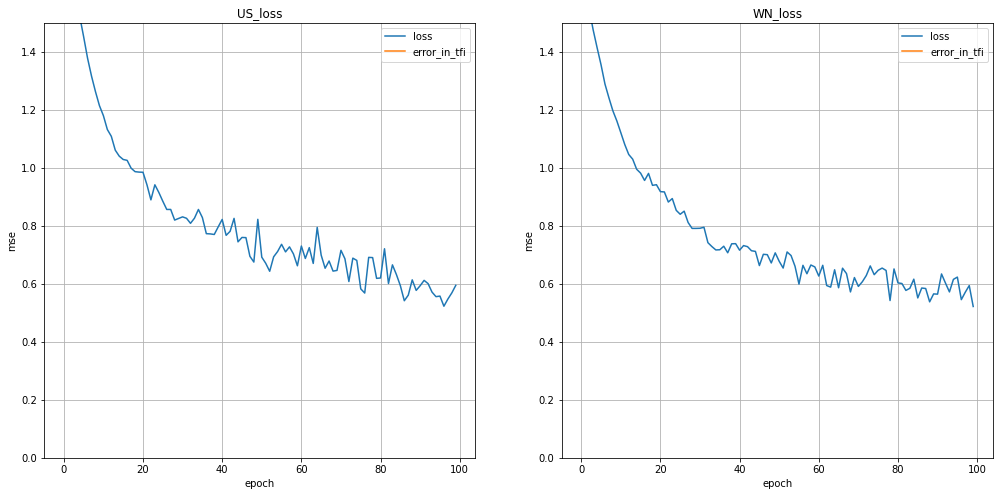

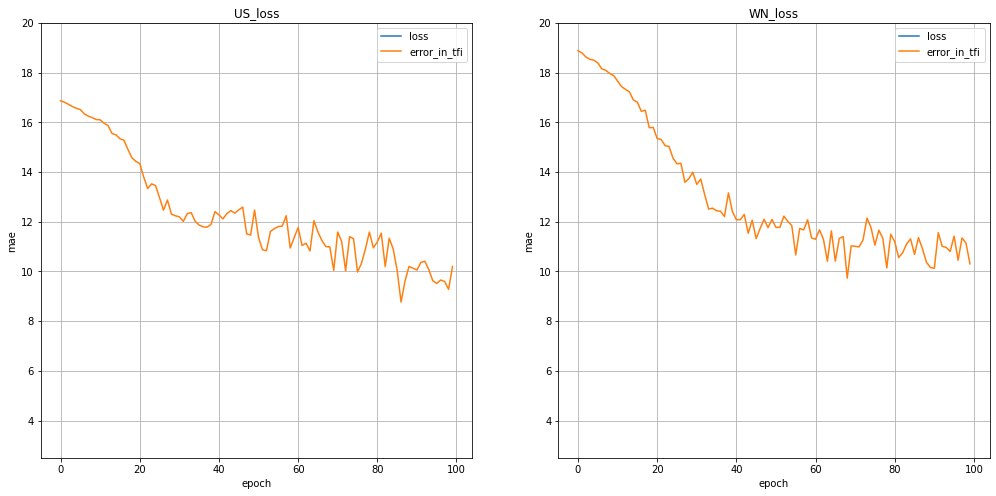

In [55]:
#show learning curves
#mean training loss measured over each epoch
#mean validation loss measured at the end of each epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(17,8))
US_plot = pd.DataFrame(US_history.history) #selecting columns
WN_plot = pd.DataFrame(WN_history.history)
US_plot.plot(ax=axes[0],ylim=(0,20),title="US_loss",xlabel='epoch',ylabel='loss').grid(True)
WN_plot.plot(ax=axes[1],ylim=(0,20),title="WN_loss",xlabel='epoch',ylabel='loss').grid(True)
plt.savefig("plots/loss_and_matrics.png")

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(17,8))
US_plot = pd.DataFrame(US_history.history) #selecting columns
WN_plot = pd.DataFrame(WN_history.history)
US_plot.plot(ax=axes[0],ylim=(0,1.5),title="US_loss",xlabel='epoch',ylabel='mse').grid(True)
WN_plot.plot(ax=axes[1],ylim=(0,1.5),title="WN_loss",xlabel='epoch',ylabel='mse').grid(True)
plt.savefig("plots/loss.png")

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(17,8))
US_plot = pd.DataFrame(US_history.history) #selecting columns
WN_plot = pd.DataFrame(WN_history.history)
US_plot.plot(ax=axes[0],ylim=(2.5,20),title="US_loss",xlabel='epoch',ylabel='mae').grid(True)
WN_plot.plot(ax=axes[1],ylim=(2.5,20),title="WN_loss",xlabel='epoch',ylabel='mae').grid(True)
plt.savefig("plots/matrics.png")

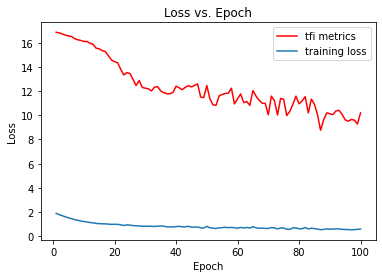

In [60]:
def plot_loss(history):
        train_loss=history.history['loss']
        train_metrics=history.history['error_in_tfi']
        x=list(range(1,len(train_metrics)+1))
        plt.plot(x,train_metrics,color='red',label='tfi metrics')
        plt.plot(x,train_loss,label='training loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()

plot_loss(US_history)

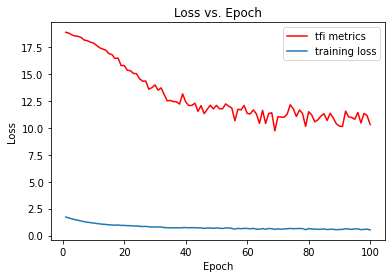

In [61]:
def plot_loss(history):
        train_loss=history.history['loss']
        train_metrics=history.history['error_in_tfi']
        x=list(range(1,len(train_metrics)+1))
        plt.plot(x,train_metrics,color='red',label='tfi metrics')
        plt.plot(x,train_loss,label='training loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()

plot_loss(WN_history)